In [32]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb

pd.options.display.float_format = '{:.5f}'.format

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
# 전체 경로
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'

# 파일 경로
train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv')

# 파일 변수에 저장
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
print("train data shape {}".format(train_data.shape)) # 훈련 데이터 크기 확인
print("test data shape {}".format(test_data.shape)) # 시험 데이터 크기 확인
print()
print("train data feature :\n", train_data.columns) # 훈련 컬럼명 조회
print("test data feature :\n", test_data.columns) # 시험 컬럼명 조회

train data shape (15035, 21)
test data shape (6468, 20)

train data feature :
 Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
test data feature :
 Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
# 데이터 정보 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [6]:
# 데이터 미리보기
train_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [16]:
# 훈련 데이터 세부사항 확인
check = pd.concat([train_data.isnull().sum(), train_data.dtypes, train_data.nunique(), train_data.describe().T], axis=1)
check.rename(columns={0:'null', 1:'type', 2:'unique'}, inplace=True)
check

,null,type,unique,count,mean,std,min,25%,50%,75%,max
id,0,int64,15035,15035.00000,7517.00000,4340.37498,0.00000,3758.50000,7517.00000,11275.50000,15034.00000
date,0,int64,13,15035.00000,201438.54599,44.25205,201405.00000,201407.00000,201410.00000,201502.00000,201505.00000
price,0,float64,3263,15035.00000,540682.65314,371524.66039,78000.00000,322000.00000,450000.00000,645000.00000,7700000.00000
bedrooms,0,int64,11,15035.00000,3.36914,0.90272,0.00000,3.00000,3.00000,4.00000,10.00000
bathrooms,0,float64,29,15035.00000,2.11506,0.76752,0.00000,1.75000,2.25000,2.50000,8.00000
sqft_living,0,int64,863,15035.00000,2083.79022,922.13409,290.00000,1430.00000,1910.00000,2560.00000,13540.00000
sqft_lot,0,int64,7678,15035.00000,15296.96581,42612.82137,520.00000,5027.50000,7620.00000,10695.50000,1651359.00000
floors,0,float64,6,15035.00000,1.49807,0.53852,1.00000,1.00000,1.50000,2.00000,3.50000
waterfront,0,int64,2,15035.00000,0.00712,0.08406,0.00000,0.00000,0.00000,0.00000,1.00000
view,0,int64,5,15035.00000,0.23425,0.76338,0.00000,0.00000,0.00000,0.00000,4.00000


In [17]:
# 훈련 데이터 세부사항 확인
test_check = pd.concat([test_data.isnull().sum(), test_data.dtypes, test_data.nunique(), test_data.describe().T], axis=1)
test_check.rename(columns={0:'null', 1:'type', 2:'unique'}, inplace=True)
test_check

,null,type,unique,count,mean,std,min,25%,50%,75%,max
id,0,int64,6468,6468.00000,18268.50000,1867.29510,15035.00000,16651.75000,18268.50000,19885.25000,21502.00000
date,0,int64,13,6468.00000,201438.85699,44.35227,201405.00000,201407.00000,201410.00000,201502.00000,201505.00000
bedrooms,0,int64,13,6468.00000,3.37786,0.99064,0.00000,3.00000,3.00000,4.00000,33.00000
bathrooms,0,float64,27,6468.00000,2.11831,0.77585,0.00000,1.75000,2.25000,2.50000,6.75000
sqft_living,0,int64,636,6468.00000,2075.98129,910.61300,370.00000,1420.00000,1920.00000,2520.00000,9640.00000
sqft_lot,0,int64,4081,6468.00000,14699.15785,38704.27667,681.00000,5084.00000,7607.00000,10664.25000,1164794.00000
floors,0,float64,6,6468.00000,1.48833,0.54401,1.00000,1.00000,1.00000,2.00000,3.50000
waterfront,0,int64,2,6468.00000,0.00866,0.09265,0.00000,0.00000,0.00000,0.00000,1.00000
view,0,int64,5,6468.00000,0.23547,0.77362,0.00000,0.00000,0.00000,0.00000,4.00000
condition,0,int64,5,6468.00000,3.41682,0.65827,1.00000,3.00000,3.00000,4.00000,5.00000


**date**

In [9]:
check.loc[['date']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
date,0,object,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# date 값 미리보기
train_data['date'][:5]

0    20141013T000000
1    20150225T000000
2    20150218T000000
3    20140627T000000
4    20150115T000000
Name: date, dtype: object

In [7]:
# date 형식 object에서 int로 변환 (yyyymmddT000000에서 yyyymmdd로)
train_data['date'] = train_data['date'].apply(lambda x : str(x[:6])).astype(int)
test_data['date'] = test_data['date'].apply(lambda x : str(x[:6])).astype(int)

In [12]:
# 변경 확인
check = pd.concat([train_data.isnull().sum(), train_data.dtypes, train_data.nunique(), train_data.describe().T], axis=1)
check.rename(columns={0:'null', 1:'type', 2:'unique'}, inplace=True)
check.loc[['date']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
date,0,int64,13,15035.0,201438.545993,44.25205,201405.0,201407.0,201410.0,201502.0,201505.0


**waterfront**

In [13]:
check.loc[['waterfront']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
waterfront,0,int64,2,15035.0,0.007117,0.084063,0.0,0.0,0.0,0.0,1.0


In [14]:
# 훈련 데이터의 waterfront 값과 값의 비중
train_data['waterfront'].value_counts(normalize = True)

0    0.992883
1    0.007117
Name: waterfront, dtype: float64

In [15]:
# 시험 데이터의 waterfront 값과 값의 비중
test_data['waterfront'].value_counts(normalize = True)

0    0.991342
1    0.008658
Name: waterfront, dtype: float64

- waterfront의 고유값은 0과 1이고, 전체 데이터에서 값이 0인 비율이 높음

**view**

In [16]:
check.loc[['view']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
view,0,int64,5,15035.0,0.234253,0.763376,0.0,0.0,0.0,0.0,4.0


In [17]:
# 훈련 데이터의 view 값과 값의 개수
train_data['view'].value_counts(normalize = True)

0    0.901097
2    0.044230
3    0.024809
1    0.016029
4    0.013834
Name: view, dtype: float64

In [18]:
# 시험 데이터의 view 값과 값의 개수
test_data['view'].value_counts(normalize = True)

0    0.902443
2    0.045918
3    0.020717
4    0.016852
1    0.014069
Name: view, dtype: float64

- 전체 데이터에서 값이 0인 비율이 높음

**yr_renovated**

In [19]:
check.loc[['yr_renovated']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
yr_renovated,0,int64,65,15035.0,83.798936,400.398498,0.0,0.0,0.0,0.0,2015.0


In [20]:
# 시험 데이터 동일 지표 비교
test_check.loc[['yr_renovated']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
yr_renovated,0,int64,61,6468.0,86.933983,407.21087,0.0,0.0,0.0,0.0,2015.0


In [21]:
train_data['yr_renovated'].unique()

array([   0, 2002, 1999, 1991, 1978, 2005, 2008, 2003, 1994, 1984, 1954,
       2014, 2011, 1974, 1983, 2013, 1990, 1957, 1977, 1981, 1995, 2000,
       1986, 1992, 2004, 2007, 1987, 2006, 1985, 1971, 1945, 1979, 1997,
       2010, 1969, 1948, 2009, 1970, 2015, 1989, 2001, 1968, 2012, 1963,
       1993, 1962, 1972, 1980, 1998, 1955, 1996, 1950, 1956, 1982, 1988,
       1940, 1946, 1975, 1964, 1958, 1976, 1973, 1967, 1965, 1944])

In [22]:
# 훈련 데이터에서 재건축 하지 않은 경우(0)와 재건축한 경우(1)의 비중
pd.cut(train_data.yr_renovated, bins = [-1, 0, 3000], labels = [0, 1]).value_counts(normalize = True)

0    0.958031
1    0.041969
Name: yr_renovated, dtype: float64

In [23]:
# 시험 데이터에서 재건축 하지 않은 경우(0)와 재건축한 경우(1)의 비중
pd.cut(test_data.yr_renovated, bins = [-1, 0, 3000], labels = [0, 1]).value_counts(normalize = True)

0    0.956401
1    0.043599
Name: yr_renovated, dtype: float64

- 재건축한 연도와 재건축하지 않은 경우
- yr_built(집의 건축 연도)와 병합을 고려

**sqft_living, sqft_living15**

In [24]:
check.loc[['sqft_living', 'sqft_living15']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
sqft_living,0,int64,863,15035.0,2083.790223,922.134087,290.0,1430.0,1910.0,2560.0,13540.0
sqft_living15,0,int64,682,15035.0,1992.754772,691.456442,399.0,1490.0,1850.0,2360.0,6210.0


In [25]:
test_check.loc[['sqft_living', 'sqft_living15']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
sqft_living,0,int64,636,6468.0,2075.981293,910.613001,370.0,1420.0,1920.0,2520.0,9640.0
sqft_living15,0,int64,502,6468.0,1974.429654,671.597761,460.0,1480.0,1820.0,2370.0,5610.0


- 주거공간의 면적과 15년 기준 주거공간의 면적을 비교하면 std, max의 다소 차이가 있음
- 훈련 데이터의 max, min과 시험 데이터의 max, min의 차이가 크므로 이상치 제거 고려

**sqft_lot, sqft_lot15**

In [26]:
check.loc[['sqft_lot', 'sqft_lot15']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
sqft_lot,0,int64,7678,15035.0,15296.965813,42612.821375,520.0,5027.5,7620.0,10695.5,1651359.0
sqft_lot15,0,int64,6958,15035.0,12823.884935,27736.259787,651.0,5100.0,7610.0,10076.0,871200.0


In [27]:
# 시험 데이터 동일 지표 비교
test_check.loc[['sqft_lot', 'sqft_lot15']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
sqft_lot,0,int64,4081,6468.0,14699.157854,38704.276666,681.0,5084.0,7607.0,10664.25,1164794.0
sqft_lot15,0,int64,3792,6468.0,12659.800402,26380.422371,748.0,5100.0,7664.5,10125.00,438213.0


- 부지 면적과 15년 기준 부지 면적을 비교하면 std, min, max의 다소 차이가 있음
- 훈련 데이터의  max, min과 시험 데이터의 max, min이 큰 차이를 보이므로 이상치 제거 고려

**price**

In [28]:
check.loc[['price']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
price,0,float64,3263,15035.0,540682.653143,371524.66039,78000.0,322000.0,450000.0,645000.0,7700000.0


- std, mean과 median(50%) 큰 차이

**sqft_above**

In [29]:
check.loc[['sqft_above']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
sqft_above,0,int64,789,15035.0,1794.158164,831.738609,290.0,1190.0,1570.0,2230.0,9410.0


In [30]:
# 시험 데이터 동일 지표 비교
test_check.loc[['sqft_above']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
sqft_above,0,int64,586,6468.0,1779.556277,820.834051,370.0,1200.0,1550.0,2190.0,8020.0


- 훈련 데이터의 max, min과 시험 데이터의 max, min이 큰 차이를 보이므로 이상치 제거를 고려

**sqft_basement**

In [31]:
check.loc[['sqft_basement']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
sqft_basement,0,int64,271,15035.0,289.632059,440.663284,0.0,0.0,0.0,550.0,4130.0


In [32]:
# 시험 데이터 동일 지표 비교
test_check.loc[['sqft_basement']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
sqft_basement,0,int64,225,6468.0,296.425015,447.218709,0.0,0.0,0.0,590.0,4820.0


- 훈련 데이터의 max와 시험 데이터의 max가 큰 차이를 보이므로 해당 열 제거를 고려

**target**

<AxesSubplot:xlabel='price', ylabel='Density'>

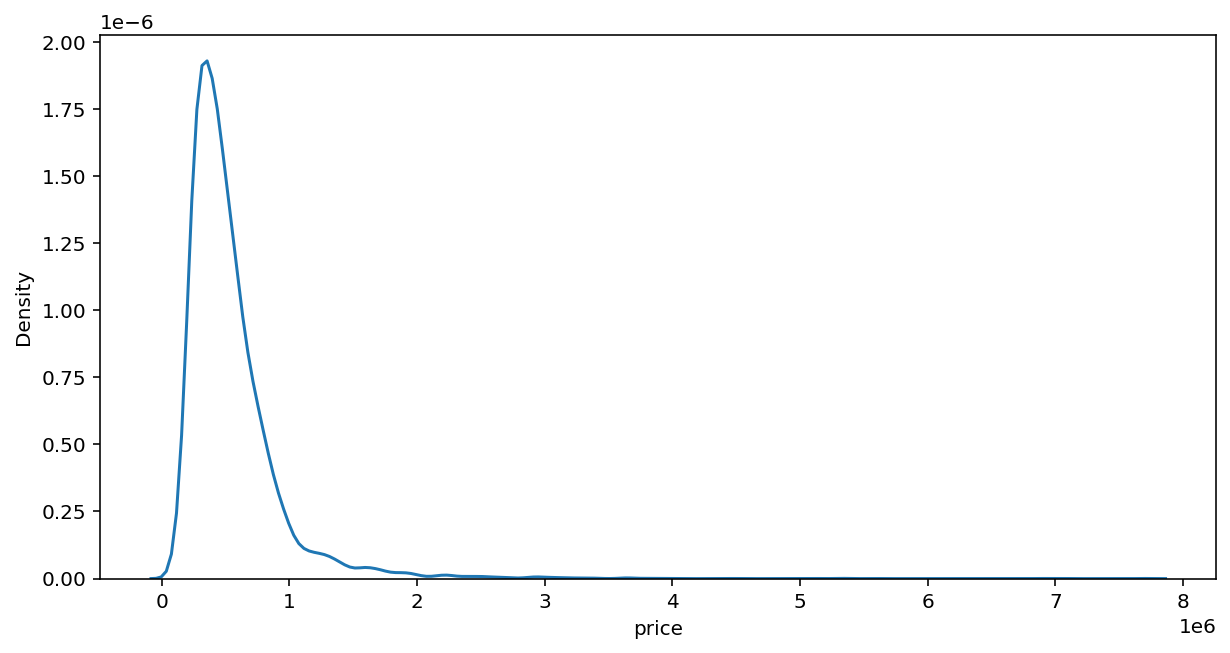

In [33]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.kdeplot(train_data['price'])

In [18]:
train_data['price'].describe()

count     15035.00000
mean     540682.65314
std      371524.66039
min       78000.00000
25%      322000.00000
50%      450000.00000
75%      645000.00000
max     7700000.00000
Name: price, dtype: float64

In [13]:
print("왜도:", train_data['price'].skew())
print("첨도:", train_data['price'].kurt())

왜도: 4.290252396939529
첨도: 40.15491919350329


In [35]:
# 변수별 가격과의 상관관계
train_data.corrwith(train_data['price'], method = 'spearman').sort_values(ascending = False)

price            1.000000
grade            0.662125
sqft_living      0.646482
sqft_living15    0.573777
sqft_above       0.547868
bathrooms        0.498989
lat              0.450692
bedrooms         0.350185
floors           0.328674
view             0.291720
sqft_basement    0.245304
waterfront       0.113179
yr_renovated     0.112381
yr_built         0.097844
sqft_lot         0.080554
long             0.071757
sqft_lot15       0.065771
id               0.036892
condition        0.021520
date            -0.001679
zipcode         -0.009266
dtype: float64

**grade**

<AxesSubplot:xlabel='grade', ylabel='price'>

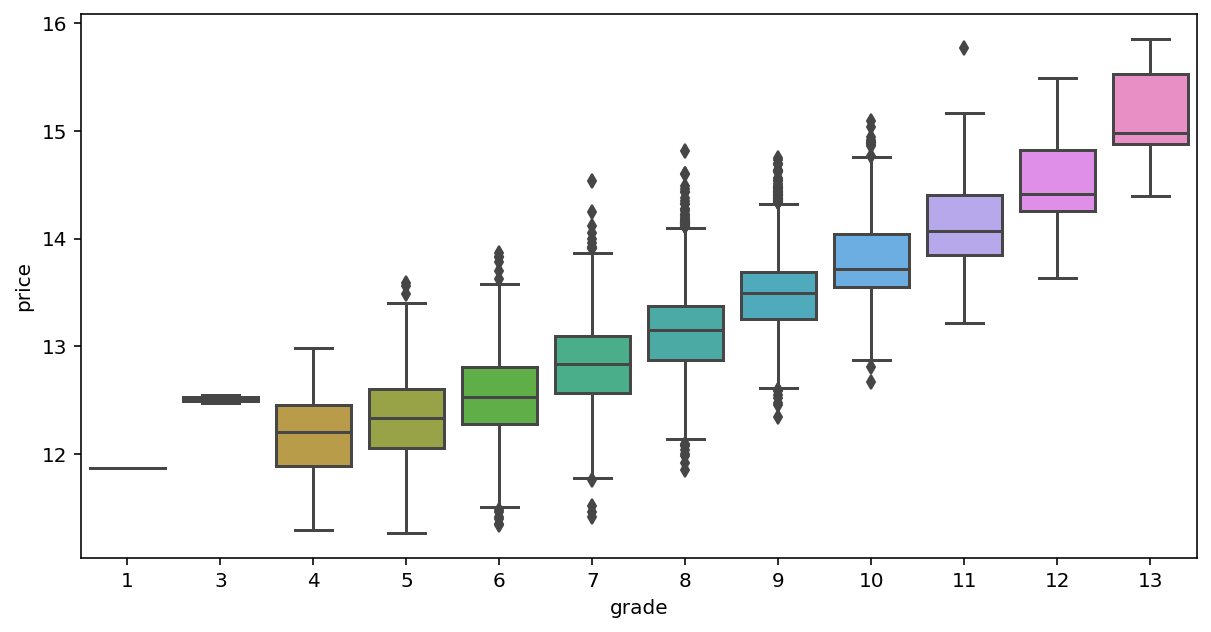

In [36]:
fig, ax = plt.subplots(figsize = (10, 5))

data = pd.concat([train_data['grade'], train_data['price']], axis = 1)
sns.boxplot(x = 'grade', y = 'price', data = data)

- 3등급, 11등급 이상치 제거 고려
- 7등급 ~ 9등급 큰 분산

**sqft_living, sqft_living15**

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

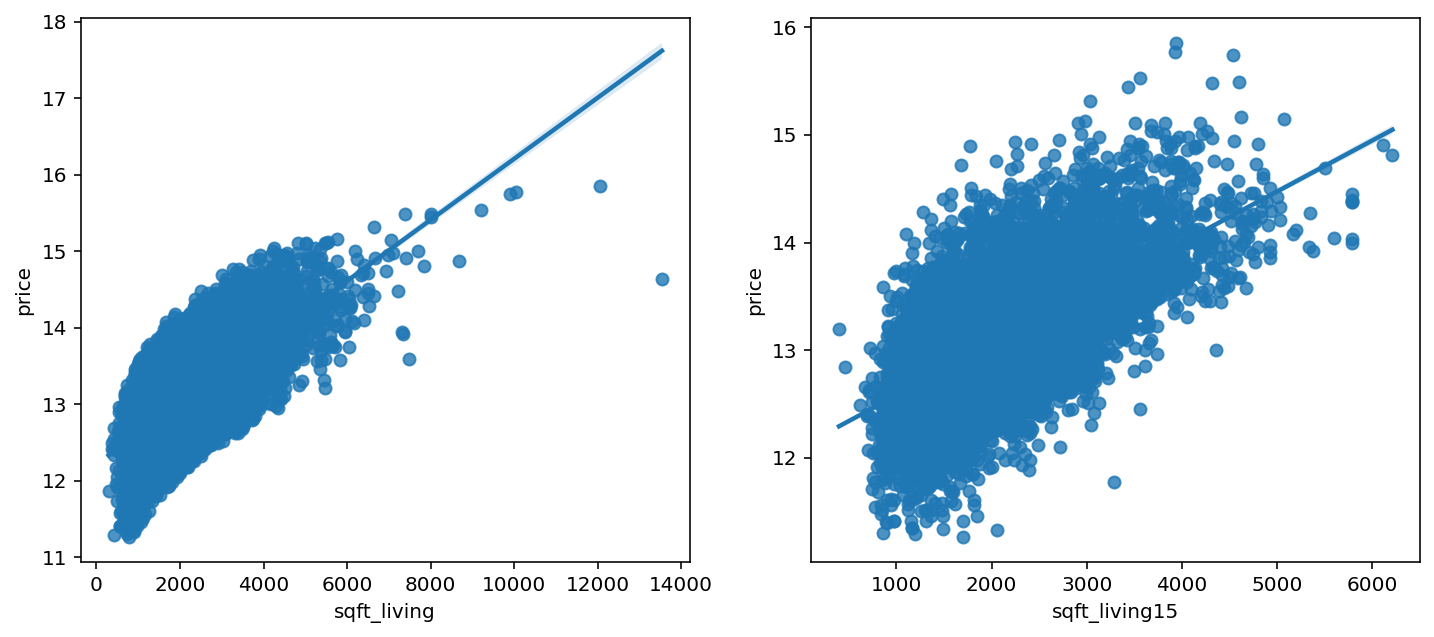

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

data = pd.concat([train_data['sqft_living'], train_data['price']], axis = 1)
sns.regplot(x = 'sqft_living', y = 'price', data = data, ax = ax[0])

data = pd.concat([train_data['sqft_living15'], train_data['price']], axis = 1)
sns.regplot(x = 'sqft_living15', y = 'price', data = data, ax = ax[1])

- sqft_living의 큰 평수에 대한 이상치 제거 고려
- sqft_living15 큰 분산

**sqft_above**

<AxesSubplot:xlabel='sqft_above', ylabel='price'>

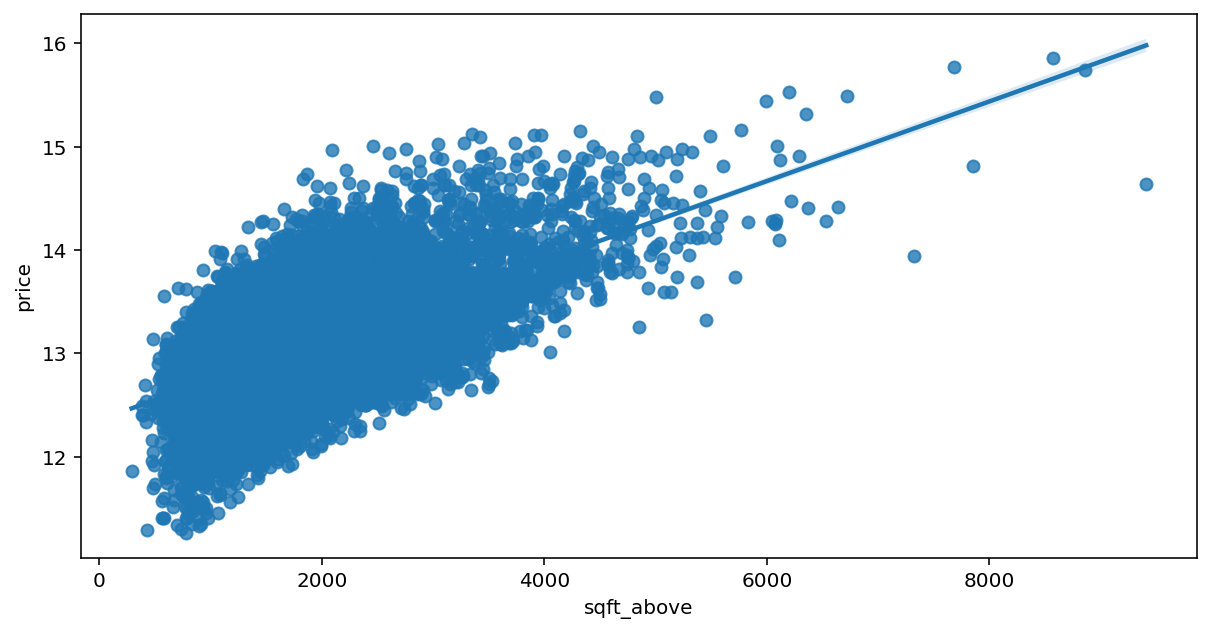

In [38]:
fig, ax = plt.subplots(figsize = (10, 5))

data = pd.concat([train_data['sqft_above'], train_data['price']], axis = 1)
sns.regplot(x = 'sqft_above', y = 'price', data = data)

**bathrooms**

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

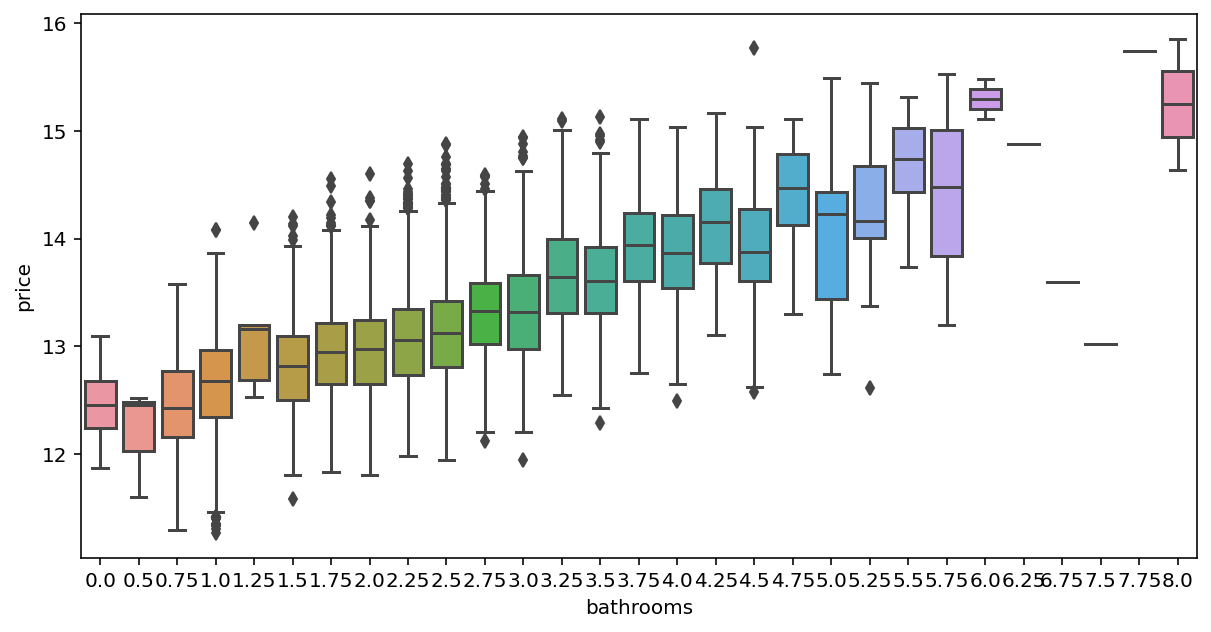

In [39]:
fig, ax = plt.subplots(figsize = (10, 5))

data = pd.concat([train_data['bathrooms'], train_data['price']], axis = 1)
sns.boxplot(x = 'bathrooms', y = 'price', data = data)

In [40]:
check.loc[['bathrooms']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
bathrooms,0,float64,29,15035.0,2.115065,0.767519,0.0,1.75,2.25,2.5,8.0


In [41]:
test_check.loc[['bathrooms']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
bathrooms,0,float64,27,6468.0,2.118313,0.775851,0.0,1.75,2.25,2.5,6.75


In [42]:
# 훈련 데이터의 화장실 개수별 비중
pd.cut(train_data.bathrooms, bins = [-1, 1, 3, 5, 7, 9], labels = ['0~1', '2~3', '4~5', '6~7', '7~']).value_counts(normalize = True)

2~3    0.731626
0~1    0.181377
4~5    0.085068
6~7    0.001663
7~     0.000266
Name: bathrooms, dtype: float64

In [43]:
# 시험 데이터의 화장실 개수별 비중
pd.cut(test_data.bathrooms, bins = [-1, 1, 3, 5, 7, 9], labels = ['0~1', '2~3', '4~5', '6~7', '7~']).value_counts(normalize = True)

2~3    0.730983
0~1    0.182127
4~5    0.084725
6~7    0.002165
7~     0.000000
Name: bathrooms, dtype: float64

- 0.5: 화장실, 0.75: 화장실과 샤워실, 1: 화장실과 샤워실 그리고 욕조 
- 화장실이 6.75개 이상인 경우 시험 데이터에 존재하지 않으므로 이상치 제거 고려

**bedrooms**

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

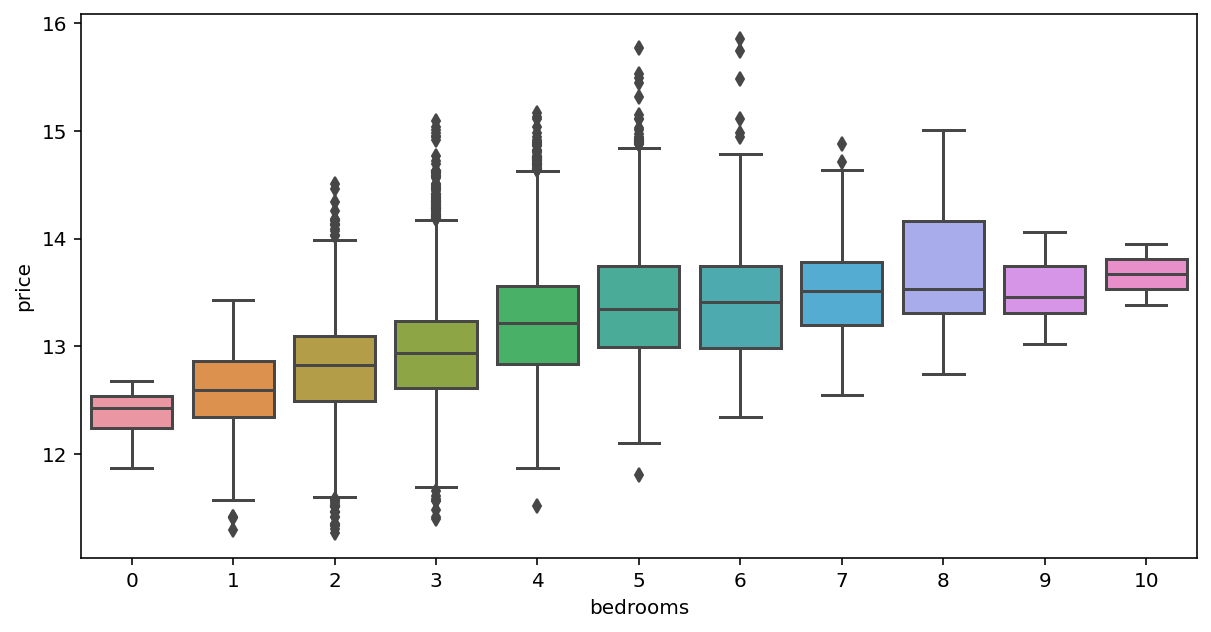

In [44]:
fig, ax = plt.subplots(figsize = (10, 5))

data = pd.concat([train_data['bedrooms'], train_data['price']], axis = 1)
sns.boxplot(x = 'bedrooms', y = 'price', data = data)

In [45]:
check.loc[['bedrooms']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
bedrooms,0,int64,11,15035.0,3.369139,0.902721,0.0,3.0,3.0,4.0,10.0


In [46]:
test_check.loc[['bedrooms']]

,null,type,unique,count,mean,std,min,25%,50%,75%,max
bedrooms,0,int64,13,6468.0,3.37786,0.99064,0.0,3.0,3.0,4.0,33.0


In [47]:
# 훈련 데이터의 침실 값과 값의 개수
pd.cut(train_data.bedrooms, bins = [-1, 0, 3, 6, 10, 33], labels = ['0', '1~3', '3~5', '6~10', '11~']).value_counts()

1~3     8899
3~5     6093
6~10      39
0          4
11~        0
Name: bedrooms, dtype: int64

In [48]:
# 시험 데이터의 침실 값과 값의 개수
pd.cut(test_data.bedrooms, bins = [-1, 0, 3, 6, 10, 33], labels = ['0', '1~3', '3~5', '6~10', '11~']).value_counts()

1~3     3806
3~5     2630
6~10      21
0          9
11~        2
Name: bedrooms, dtype: int64

In [49]:
print(train_data['bedrooms'].unique())
print(test_data['bedrooms'].unique())

[ 3  2  5  4  6  1  7  9  8  0 10]
[ 3  4  5  2  1  6  0  7  8 11 33  9 10]


- 침실의 개수 2~6의 큰 분산
- 시험 데이터의 침실이 33개인 경우 수정 고려

**categorical**

['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']


<AxesSubplot:xlabel='grade', ylabel='price'>

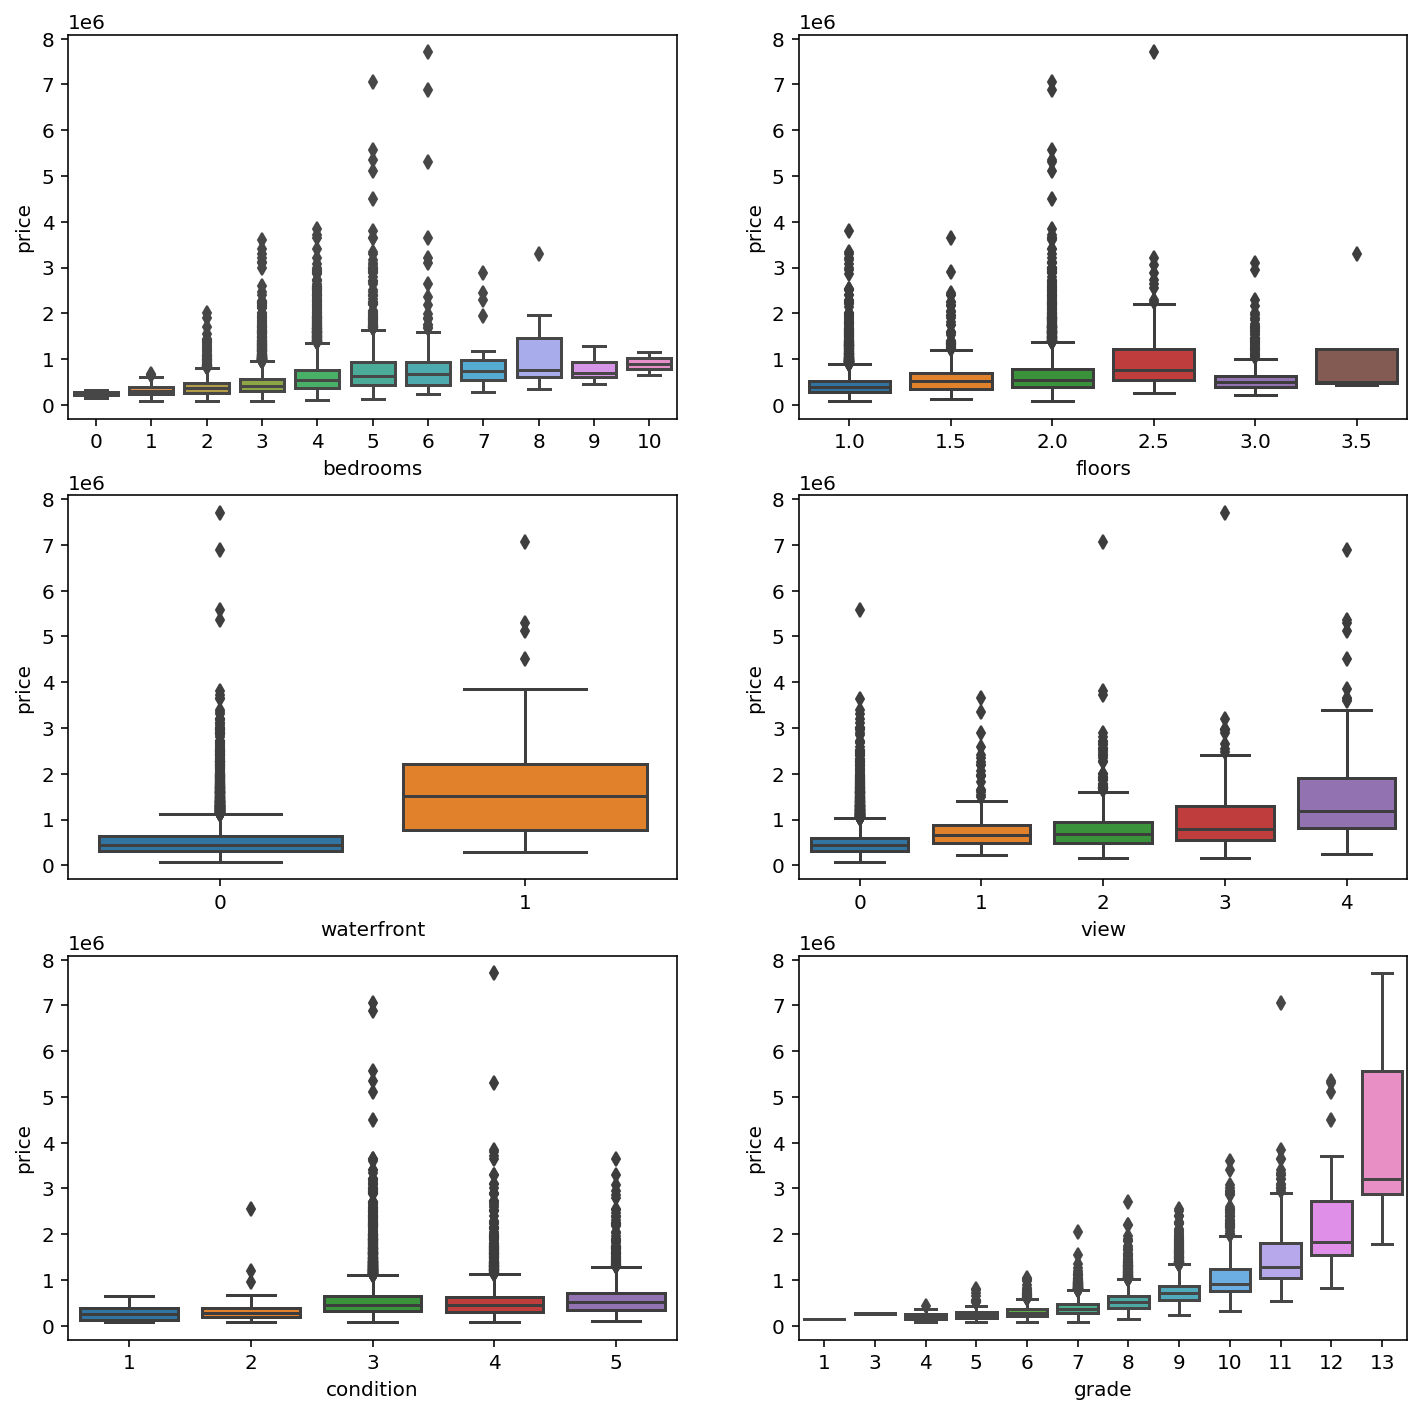

In [5]:
# 범주형 데이터 확인
categorical_list = [col for col in train_data.columns if train_data[col].nunique() < 15]
print(categorical_list)

fig, ax = plt.subplots(3, 2, figsize = (12, 12))

data = pd.concat([train_data['bedrooms'], train_data['price']], axis = 1)
sns.boxplot(x = 'bedrooms', y = 'price', data = data, ax = ax[0][0])

data = pd.concat([train_data['floors'], train_data['price']], axis = 1)
sns.boxplot(x = 'floors', y = 'price', data = data, ax = ax[0][1])

data = pd.concat([train_data['waterfront'], train_data['price']], axis = 1)
sns.boxplot(x = 'waterfront', y = 'price', data = data, ax = ax[1][0])

data = pd.concat([train_data['view'], train_data['price']], axis = 1)
sns.boxplot(x = 'view', y = 'price', data = data, ax = ax[1][1])

data = pd.concat([train_data['condition'], train_data['price']], axis = 1)
sns.boxplot(x = 'condition', y = 'price', data = data, ax = ax[2][0])

data = pd.concat([train_data['grade'], train_data['price']], axis = 1)
sns.boxplot(x = 'grade', y = 'price', data = data, ax = ax[2][1])

- 원핫 인코딩 고려

**skewness**

In [10]:
# 왜도 확인
print("{:<15} {:<15} {:<15}".format('Type','Columns','Skewness'))
for col in train_data.columns:
    if train_data[col].skew() < -2:
        print("{:<15} {:<15} {:<15}".format('Negative', col, train_data[col].skew()))
    elif 2 < train_data[col].skew():
        print("{:<15} {:<15} {:<15}".format('Positive', col, train_data[col].skew()))

Type            Columns         Skewness       
Positive        price           4.290252396939529
Positive        sqft_lot        13.35050013446013
Positive        waterfront      11.728112870701265
Positive        view            3.3787675184986727
Positive        yr_renovated    4.569374459835021
Positive        sqft_lot15      10.028411904577348


<AxesSubplot:xlabel='sqft_lot15', ylabel='Density'>

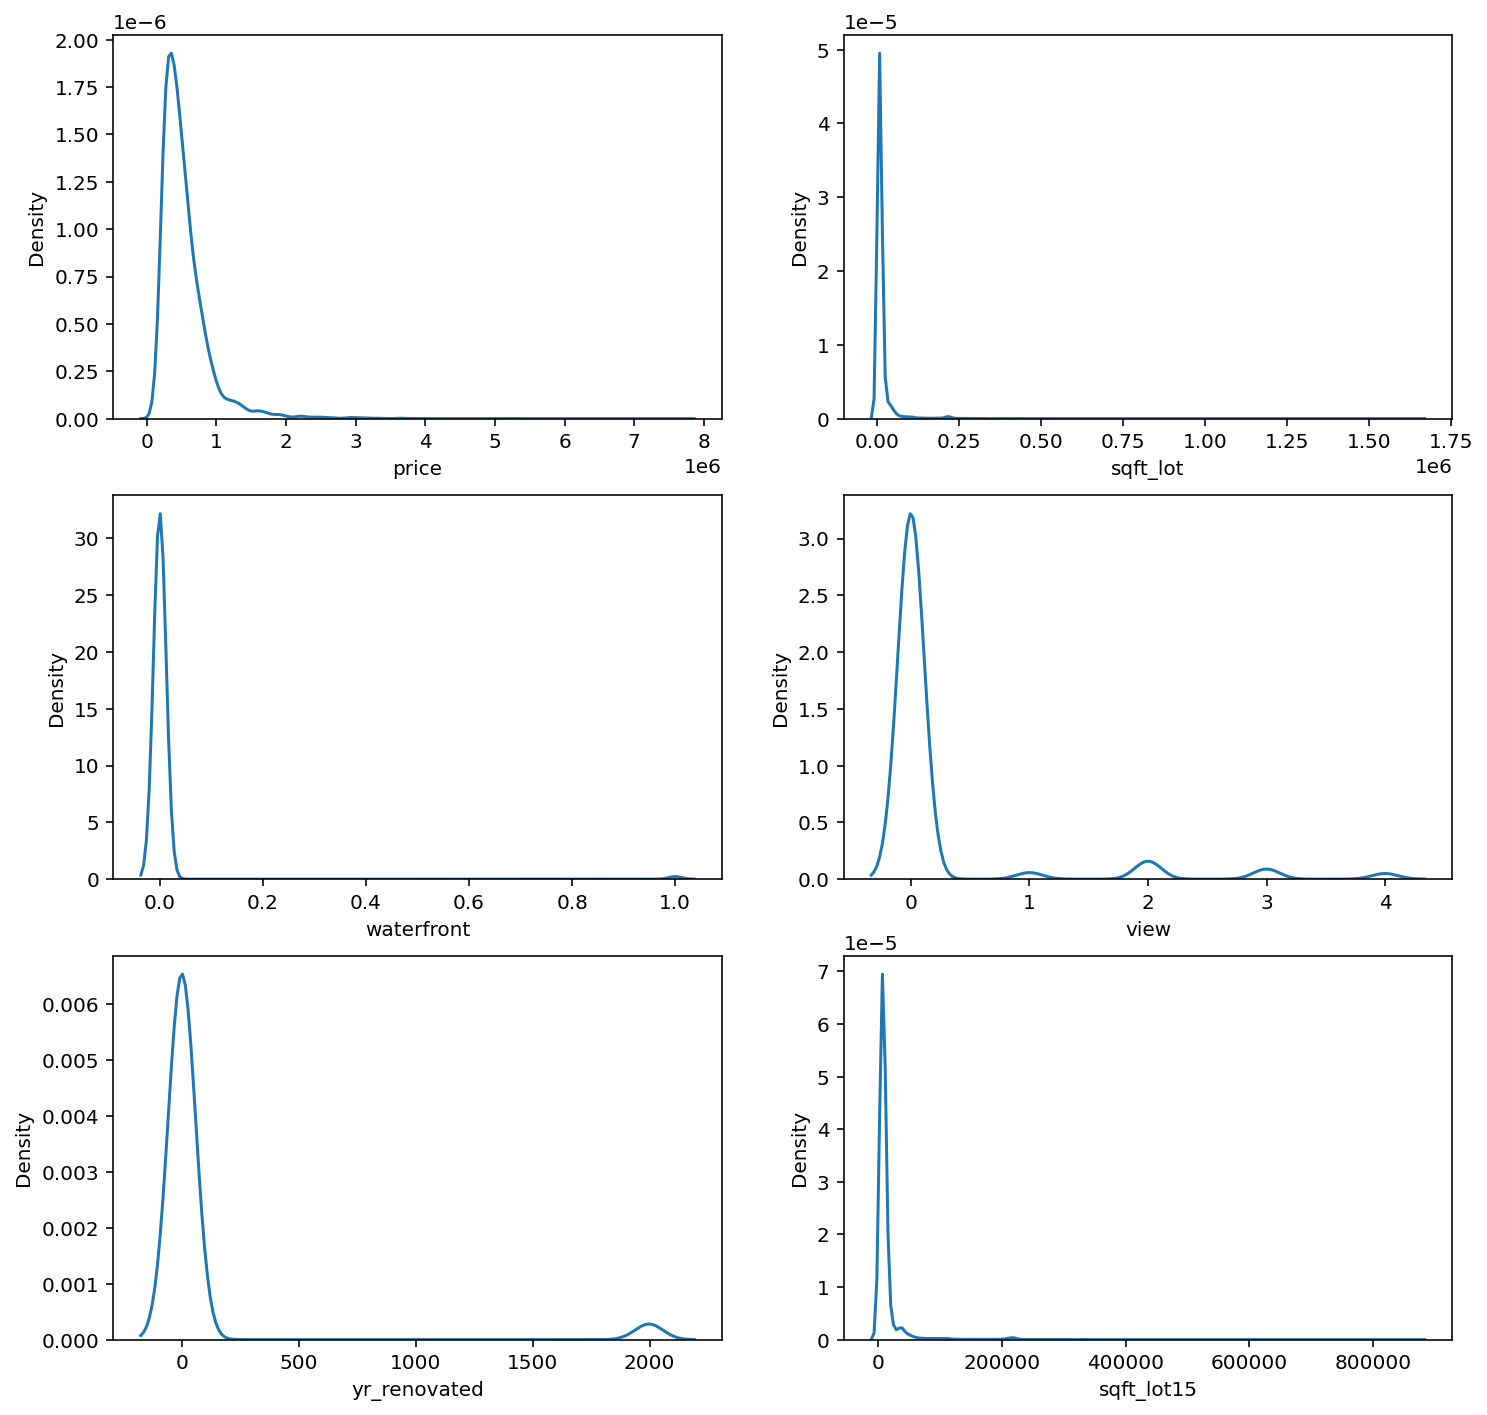

In [21]:
# 편향 데이터 확인
fig, ax = plt.subplots(3, 2, figsize = (12, 12))

sns.kdeplot(train_data['price'], ax = ax[0][0])
sns.kdeplot(train_data['sqft_lot'], ax = ax[0][1])
sns.kdeplot(train_data['waterfront'], ax = ax[1][0])
sns.kdeplot(train_data['view'], ax = ax[1][1])
sns.kdeplot(train_data['yr_renovated'], ax = ax[2][0])
sns.kdeplot(train_data['sqft_lot15'], ax = ax[2][1])

**lat & long**

<AxesSubplot:xlabel='long', ylabel='lat'>

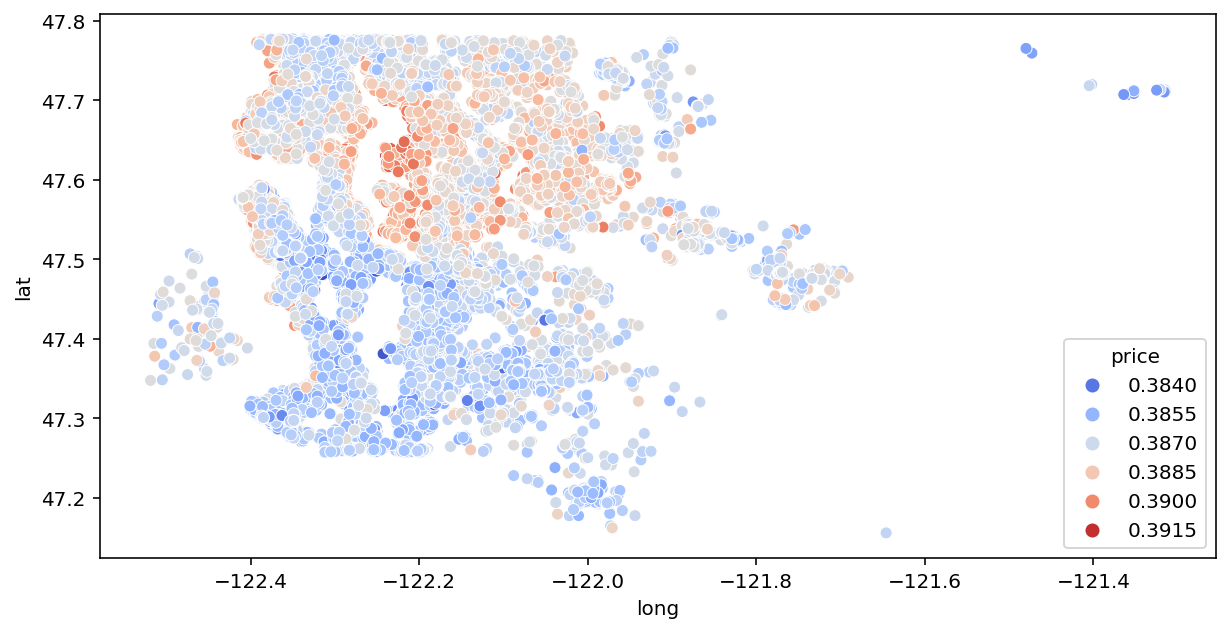

In [34]:
train_data['price'] = np.log1p(train_data['price']) 

data = pd.concat([train_data['long'], train_data['lat'], train_data['price']], axis = 1)
fig, ax = plt.subplots(figsize = (10, 5))
sns.scatterplot(x = 'long', y = 'lat', hue = 'price', data = data, palette = 'coolwarm')

**Feature Importance**

In [35]:
y = train_data['price']
del train_data['price']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

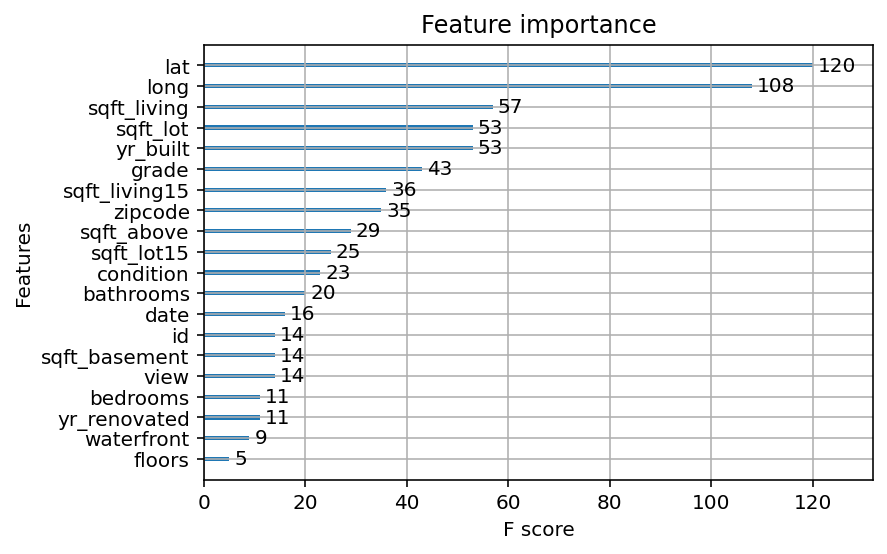

In [44]:
model = xgb.XGBRegressor(random_state = 9)
model.fit(train_data, y)

xgb.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

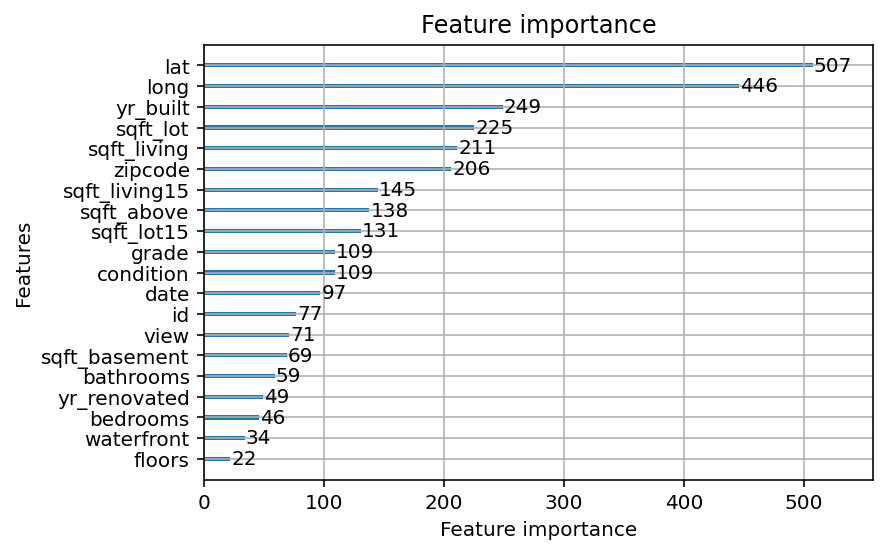

In [45]:
# lgb 임시 모델 
model = lgb.LGBMRegressor(random_state = 9)
model.fit(train_data, y)

lgb.plot_importance(model)